https://www.census.gov/programs-surveys/nsch/data/datasets.2020.html#list-tab-491554181

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
# topical is detailed questionnaire of  one sampled child from the screener
# topical_2022 = pd.read_stata('.\\datasets\\2022\\nsch_2022e_topical.dta')
topical_2022 = pd.read_stata('./datasets/2022/nsch_2022e_topical.dta')
# topical_2021 = pd.read_stata('.\\datasets\\2021\\nsch_2021e_topical.dta')

# # combined dataset
# df = pd.concat([topical_2022, topical_2021])

# topical_2022.keys() #490
# topical_2021.keys() #463

In [43]:
data = topical_2022.copy()

In [18]:
# Pre-processing
# imputer = SimpleImputer(strategy='mean')
# data_final = pd.DataFrame(imputer.fit_transform(data_final), columns = data_final.columns)

In [44]:
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

# don't include: stratum (1 or 2a), householdid, formtype (1-3), k2q31d (add medication), any of previous targets
ex_features = ['stratum', 'hhid', 'formtype', 'addtreat', 'k2q31d', 'k2q31a', 'k2q31c']
data = data.drop(columns = ex_features)

In [48]:
# calculate n for each target category
noADD = (data[target_variable] == 0).sum()
sev1 = (data[target_variable] == 1).sum()
sev2 = (data[target_variable] == 2).sum()
sev3 = (data[target_variable] == 3).sum()

In [66]:
# Identify features with high correlation with the target

# Automatically identify numerical and categorical columns
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Convert categorical columns to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

correlation_matrix = data_encoded.corr()

# Extract the correlation of the target variable with all other variables (exclude the target variable)
target_correlation = correlation_matrix[target_variable].sort_values(ascending=False).drop(target_variable)

# Create a heatmap for correlation with the target variable
# plt.figure(figsize=(10, 8))
# sns.heatmap(target_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title(f'Correlation with {target_variable}')
# plt.show()

highly_correlated_features = target_correlation[abs(target_correlation) > 0.2].index.tolist()

print("Features with high correlation with the target:")
print(highly_correlated_features)

Features with high correlation with the target:
['hcability', 'totcshcn', 'k2q34c', 'k7q84_r', 'k7q83_r', 'makefriend', 'k8q31', 'k7q04r_r', 'k7q85_r', 'k7q82_r', 'bullied_r', 'k8q32', 'genetic_desc', 'k2q35a_1_years', 'bully', 'hcextent', 'sesplanyr', 'c4q04', 'focuson', 'k2q33c', 'k4q37', 'k6q71_r', 'k2q38c', 'sc_k2q19', 'waitforturn', 'calmdown_r', 'arrangehc', 'k2q34b', 'menbevcov', 'k2q36a', 'k2q35a', 'k7q70_r', 'ace11', 'totnonshcn', 'k4q28x04', 'sc_k2q16', 'distracted', 'k2q32a', 'k4q36', 'errandalone', 'ssidisability', 'sc_k2q20', 'k6q15', 'k2q33a', 'k2q30a', 'k4q22_r', 'autismmed', 'sc_k2q13', 'sc_k2q10', 'sc_cshcn', 'sc_k2q22', 'k2q34a', 'k2q31b', 'memorycond', 'k4q23']


/Users/alexdhima/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexdhima/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexdhima/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


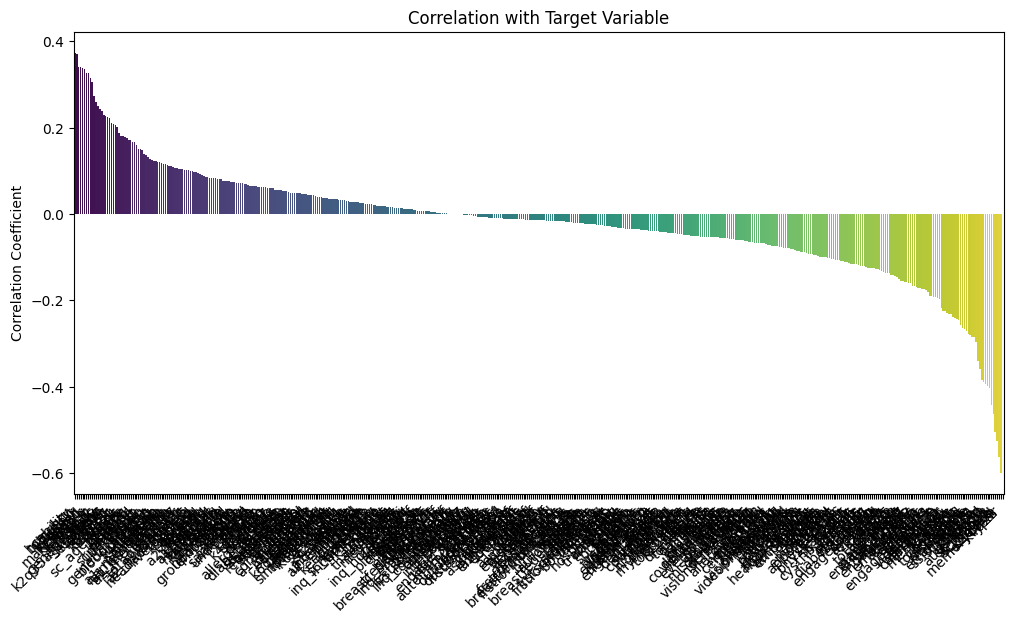

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette='viridis')
plt.title('Correlation with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [62]:
# Select relevant features and target variables
# all demographic and screening variables
# screen_features = ['AGEPOS4','C_AGE_YEARS','C_CSHCN','C_ENGLISH','C_HISPANIC_R','C_K2Q10','C_K2Q11','C_K2Q12',
#                    'C_K2Q13','C_K2Q14','C_K2Q15','C_K2Q16','C_K2Q17','C_K2Q18','C_K2Q19','C_K2Q20','C_K2Q21',
#                    'C_K2Q22','C_K2Q23', 'C_RACE_R','C_SEX','HHLANGUAGE','RACER', "TOTNONSHCN",
#                    "SC_AGE_LT10", "SC_AGE_LT4", "SC_AGE_LT6", "SC_AGE_LT9", "SC_AGE_YEARS", "SC_AIAN",
#                    "SC_ASIAN", "SC_CSHCN", "SC_ENGLISH", "SC_HISPANIC_R","SC_K2Q10", "SC_K2Q11", "SC_K2Q12", 
#                    "SC_K2Q13", "SC_K2Q14", "SC_K2Q15", "SC_K2Q16", "SC_K2Q17", "SC_K2Q18", "SC_K2Q19","SC_K2Q20", 
#                    "SC_K2Q21", "SC_K2Q22", "SC_K2Q23", "SC_NHPI", "SC_RACER", "SC_RACE_R", "SC_SEX", "TENURE", 
#                    "TOTAGE_0_5", "TOTAGE_12_17", "TOTAGE_6_11", "TOTCSHCN", "TOTFEMALE", "TOTKIDS_R", "TOTMALE"
# additional_features = ['CONCUSSION', 'DISTRACTED', 'ENGAGE_PICKY', 'K10Q12', 'ACE6', 'HIGRADE', 'FPL_I1', 'HOMEEVIC']

# Exclude target variable from selected features
features = highly_correlated_features[1:]

# Filter the dataset for all selected features and target variable
X = data_encoded[features]
y = data_encoded[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.4
test_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 42)


In [63]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define and train models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Gaussian Process Classifier': GaussianProcessClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Evaluate each model
for name, model in models.items():

    accuracy = accuracy_score(y_val, y_pred)
    print(f'{name} - Validation Accuracy: {accuracy:.2f}')
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

    # Feature importance for Random Forest
    if name == 'Random Forest':
        feature_importance = model.feature_importances_
        plt.barh(selected_features, feature_importance)
        plt.xlabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()

# Choose the best model and evaluate on the test set
best_model = ''  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))